# Bert large | 56 tokens | 1e-5 | 6 no neutral = Macro F1 - 0.50 / Weighted F1 - 0.60

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2025-03-29 13:10:33.661103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 13:10:33.675175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743253833.690284    3660 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743253833.694885    3660 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743253833.708032    3660 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Load dataset
df = pd.read_csv("final_combined_dataset_sentence&emotion_only.csv")

# Iteration 4: remove neutral
df = df[df["emotion"] != "neutral"]

# Label mapping
unique_emotions = df["emotion"].unique()
label2id = {label: idx for idx, label in enumerate(sorted(unique_emotions))}
id2label = {idx: label for label, idx in label2id.items()}

# Apply mapping
df["label"] = df["emotion"].map(label2id)

# Stratified split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print for verification
print("Preprocessing complete!")
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print("Label2ID:", label2id)
print("Class Weights:", class_weights_dict)

Preprocessing complete!
Train size: 348005
Val size: 87002
Label2ID: {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5}
Class Weights: {0: 1.0786237207024592, 1: 41.42916666666667, 2: 1.4793866585046507, 3: 0.4313708719764187, 4: 0.560129342951968, 5: 3.7132415706359367}


In [4]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

# Tokenization function
def tokenize_data(sentences, labels):
    encodings = tokenizer(
        sentences.tolist(),
        padding=True,
        truncation=True,
        max_length=56,
        return_tensors="pt"
    )
    return encodings, torch.tensor(labels.tolist())

# Tokenize train and validation data
train_encodings, train_labels = tokenize_data(train_df["sentence"], train_df["label"])
val_encodings, val_labels = tokenize_data(val_df["sentence"], val_df["label"])

# Custom Dataset class
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

print("Tokenization complete. Ready for training.")


Tokenization complete. Ready for training.


In [5]:
# Load model
model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased",
    num_labels=6,
    id2label=id2label,
    label2id=label2id
)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert class weights to tensor
weights = torch.tensor(list(class_weights_dict.values()), dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# Custom compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {"macro_f1": f1, "accuracy": acc}

training_args = TrainingArguments(
    output_dir="checkpoints/bert_large_56_noneutral",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=2,
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    report_to="none",
    fp16=True
)




# Trainer with custom loss function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


# Initialize trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,0.561100,0.358628,0.790389,0.920944
2,0.327200,0.354231,0.793531,0.923347
3,0.269600,0.389370,0.788490,0.923370
4,0.210500,0.561237,0.779742,0.923209
5,0.160500,0.671375,0.782436,0.922795


TrainOutput(global_step=54380, training_loss=0.3057973476576866, metrics={'train_runtime': 5006.0824, 'train_samples_per_second': 347.582, 'train_steps_per_second': 10.863, 'total_flos': 1.773631328916216e+17, 'train_loss': 0.3057973476576866, 'epoch': 5.0})

In [7]:
trainer.save_model("bert_large_7")
tokenizer.save_pretrained("bert_large_7")

('bert_large_7/tokenizer_config.json',
 'bert_large_7/special_tokens_map.json',
 'bert_large_7/vocab.txt',
 'bert_large_7/added_tokens.json',
 'bert_large_7/tokenizer.json')

Classification Report:
              precision    recall  f1-score   support

       anger       0.66      0.57      0.61       217
     disgust       0.50      0.50      0.50         2
        fear       0.53      0.24      0.33        42
   happiness       0.70      0.79      0.74       184
     sadness       0.57      0.56      0.57       144
    surprise       0.17      0.40      0.24        25

    accuracy                           0.60       614
   macro avg       0.52      0.51      0.50       614
weighted avg       0.62      0.60      0.61       614



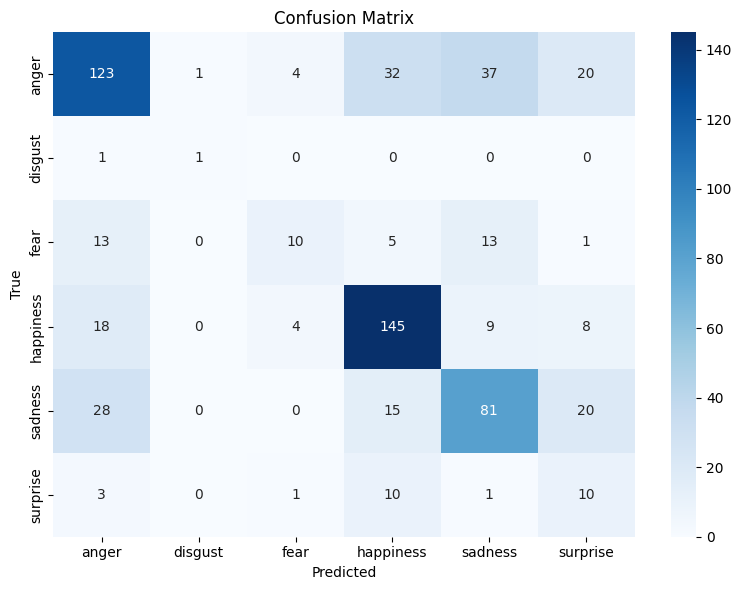

In [5]:
# Emotion mapping provided by teacher
emotion_mapping = {
    "happiness": [
        "joy", "optimism", "approval", "pride", "gratitude", "confidence",
        "satisfaction", "hope", "love", "excitement", "caring", "relief", "admiration",
        "amusement", "anticipation", "encouragement", "desire", "happiness"
    ],
    "sadness": [
        "disappointment", "nostalgia", "remorse", "pain", "stress", "regret",
        "resignation", "despair", "confusion", "uncertainty", "sadness"
    ],
    "anger": [
        "anger", "annoyance", "disapproval", "frustration", "disbelief", "warning",
        "rejection"
    ],
    "disgust": ["disgust"],
    "fear": [
        "fear", "nervousness", "worry", "anxiety", "doubt", "insecurity", "urgency",
        "panic"
    ],
    "surprise": ["surprise", "realization", "shock", "amazement", "wonder"],
    "neutral": [
        "neutral", "mixed", "trust", "agreement", "instruction", "suggestion",
        "request", "confirmation", "acceptance", "reassurance", "clarification",
        "understanding", "certainty"
    ]
}

# Reverse the mapping for fast lookup
reverse_mapping = {sub: main for main, subs in emotion_mapping.items() for sub in subs}

# Load test data
df = pd.read_excel("group 24_url1.xlsx")

# Apply mapping
df["Mapped_Emotion"] = df["Emotion"].map(reverse_mapping)

# Drop rows with unmapped emotions (should be none if clean)
df = df.dropna(subset=["Mapped_Emotion"])
df = df[df["Mapped_Emotion"] != "neutral"]

# Define label2id and id2label
core_emotions = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
label2id = {label: i for i, label in enumerate(core_emotions)}
id2label = {i: label for label, i in label2id.items()}

# Convert mapped emotion to numeric labels
df["label"] = df["Mapped_Emotion"].map(label2id)

# Tokenize
tokenizer = AutoTokenizer.from_pretrained("bert_large_7")
encodings = tokenizer(
    df["Translation"].tolist(),
    truncation=True,
    padding=True,
    max_length=56,
    return_tensors="pt"
)

# Dataset wrapper
class EmotionTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

test_dataset = EmotionTestDataset(encodings, df["label"].tolist())

# Load trained model
model = AutoModelForSequenceClassification.from_pretrained("bert_large_7")

# Predict
trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = df["label"].tolist()

# Evaluation
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=core_emotions))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=core_emotions,
            yticklabels=core_emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [6]:
# Macro F1: unweighted mean across all classes
macro_f1 = f1_score(y_true, y_pred, average="macro")
print("F1-score:", round(macro_f1, 4))

F1-score: 0.4977


In [7]:
# Macro F1: unweighted mean across all classes
macro_f1 = f1_score(y_true, y_pred, average="weighted")
print("F1-score:", round(macro_f1, 4))

F1-score: 0.6051


# Refined Test Set

Classification Report:
              precision    recall  f1-score   support

       anger       0.68      0.58      0.63       225
     disgust       0.50      0.17      0.25         6
        fear       0.47      0.16      0.23        45
   happiness       0.69      0.81      0.75       172
     sadness       0.55      0.56      0.56       140
    surprise       0.19      0.39      0.26        28

    accuracy                           0.60       616
   macro avg       0.51      0.45      0.44       616
weighted avg       0.61      0.60      0.59       616



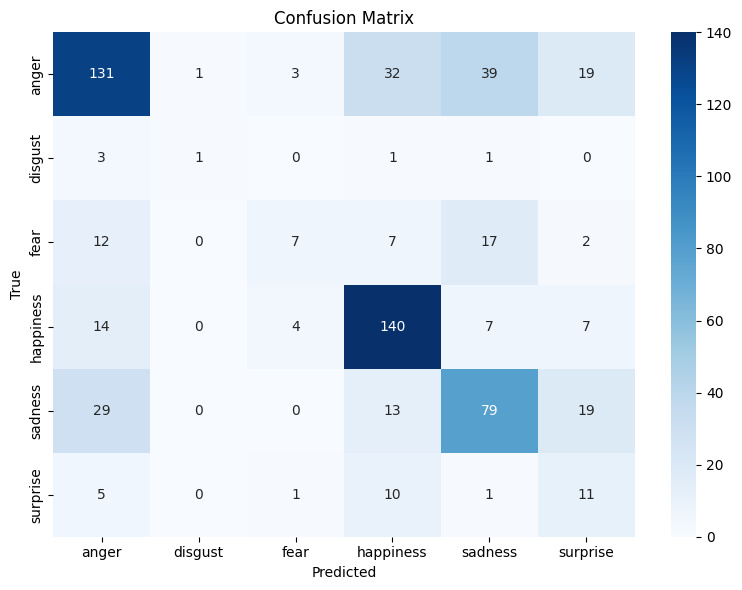

In [8]:
# Emotion mapping provided by teacher
emotion_mapping = {
    "happiness": [
        "joy", "optimism", "approval", "pride", "gratitude", "confidence",
        "satisfaction", "hope", "love", "excitement", "caring", "relief", "admiration",
        "amusement", "anticipation", "encouragement", "desire", "happiness"
    ],
    "sadness": [
        "disappointment", "nostalgia", "remorse", "pain", "stress", "regret",
        "resignation", "despair", "confusion", "uncertainty", "sadness"
    ],
    "anger": [
        "anger", "annoyance", "disapproval", "frustration", "disbelief", "warning",
        "rejection"
    ],
    "disgust": ["disgust"],
    "fear": [
        "fear", "nervousness", "worry", "anxiety", "doubt", "insecurity", "urgency",
        "panic"
    ],
    "surprise": ["surprise", "realization", "shock", "amazement", "wonder"],
    "neutral": [
        "neutral", "mixed", "trust", "agreement", "instruction", "suggestion",
        "request", "confirmation", "acceptance", "reassurance", "clarification",
        "understanding", "certainty"
    ]
}

# Reverse the mapping for fast lookup
reverse_mapping = {sub: main for main, subs in emotion_mapping.items() for sub in subs}

# Load test data
df = pd.read_excel("Test_set_refined.xlsx")

# Apply mapping
df["Mapped_Emotion"] = df["Emotion"].map(reverse_mapping)

# Drop rows with unmapped emotions (should be none if clean)
df = df.dropna(subset=["Mapped_Emotion"])
df = df[df["Mapped_Emotion"] != "neutral"]

# Define label2id and id2label
core_emotions = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
label2id = {label: i for i, label in enumerate(core_emotions)}
id2label = {i: label for label, i in label2id.items()}

# Convert mapped emotion to numeric labels
df["label"] = df["Mapped_Emotion"].map(label2id)

# Tokenize
tokenizer = AutoTokenizer.from_pretrained("bert_large_7")
encodings = tokenizer(
    df["Translation"].tolist(),
    truncation=True,
    padding=True,
    max_length=56,
    return_tensors="pt"
)

# Dataset wrapper
class EmotionTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

test_dataset = EmotionTestDataset(encodings, df["label"].tolist())

# Load trained model
model = AutoModelForSequenceClassification.from_pretrained("bert_large_7")

# Predict
trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = df["label"].tolist()

# Evaluation
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=core_emotions))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=core_emotions,
            yticklabels=core_emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [9]:
# Macro F1: unweighted mean across all classes
macro_f1 = f1_score(y_true, y_pred, average="macro")
print("F1-score:", round(macro_f1, 4))

F1-score: 0.4446


In [10]:
weighted_f1 = f1_score(y_true, y_pred, average="weighted")
print("Weighted F1-score:", round(weighted_f1, 4))


Weighted F1-score: 0.5944


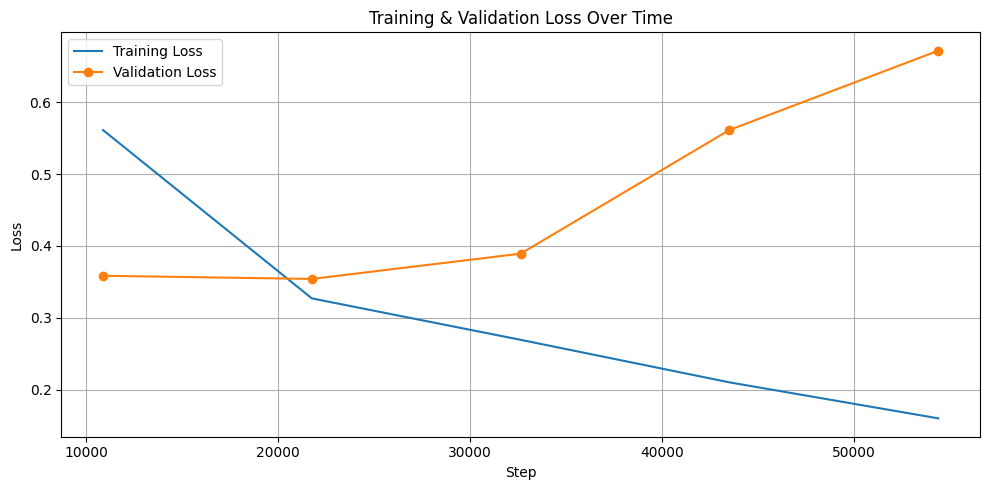

In [11]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
import json
import os

# Load the training log file
log_path = os.path.join("checkpoints/bert_large_56_noneutral/checkpoint-54380", "trainer_state.json")
with open(log_path, "r") as f:
    logs = json.load(f)

# Extract log history
history = logs["log_history"]

# Parse training and evaluation losses
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for entry in history:
    if "loss" in entry and "step" in entry:
        train_steps.append(entry["step"])
        train_losses.append(entry["loss"])
    elif "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_losses.append(entry["eval_loss"])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_losses, label="Training Loss")
plt.plot(eval_steps, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Reverse label mapping to get string labels
id2label = {v: k for k, v in label2id.items()}

# Add predictions to DataFrame
df["true_label"] = [id2label[i] for i in y_true]
df["predicted_label"] = [id2label[i] for i in y_pred]

# Filter for mismatches
false_predictions = df[df["true_label"] != df["predicted_label"]]

# Show sample of incorrect predictions
print("False predictions (sample):")
print(false_predictions[["Translation", "true_label", "predicted_label"]].sample(50, random_state=42))


False predictions (sample):
                                            Translation true_label  \
83    And he thinks I can replace everything with mo...      anger   
15    Due to Velina's behavior, scandals between Lil...      anger   
596                                   No, I want a dog.  happiness   
825                                    No, please, Mom.       fear   
772         Excuse me, do you prevent me from this rug?      anger   
693              However, Nicholas is not so fascinated    sadness   
744                                  I move out of you.  happiness   
503             And he happens to Veli to the daughter.    sadness   
19    And this, given that it works as a saleswoman ...      anger   
396         No, I'm sure it will appear from somewhere.  happiness   
159          For this act, I will think about mistakes.   surprise   
969                                    It won't be now.    sadness   
469                             He didn't want to come.    sad